# Comparing Model Resolution

Load and explore model solutions at a range of horizontal resolutions (1°, 0.25°, and 0.1°). We use snapshots of model output to explore how the velocity fields differ between the simulations. We also look at eddy kinetic energy, which highlights that coarser resolution simulations have less variability in their velocity fields.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import intake
catalog = intake.cat.access_nri
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cft

Given that the high resolution simulations contain quite a lot of data, let's fire up a Dask cluster to parallelise the computation.

In [2]:
from dask.distributed import Client

client = Client("tcp://10.6.43.39:8786")
client

<Client: 'tcp://127.0.0.1:34775' processes=7 threads=28, memory=112.00 GiB>

Now instantiate a database session.

Pick three experiments to analyse. If you want to look at a list of all the experiments available, run the following snippet.

`print(cc.querying.get_experiments(session)['experiment'].values)`

In [4]:
experiments = ['01deg_jra55v140_iaf_cycle4',
               '025deg_jra55_iaf_omip2_cycle6',
               '1deg_jra55_iaf_omip2_cycle6']

titles      = ['0.1° horizontal resolution',
               '0.25° horizontal resolution',
               '1° horizontal resolution']

For simplicity, here we load only 3 years of data. But you may load as much as you like! Also we only load one depth level, in particular the one prescribed with variable `depth` below.

In [5]:
start_time = '1980-01-01'
end_time = '1982-12-31'
depth = 0

In [6]:
sims = {}

for experiment in experiments:
    cat_subset = catalog[experiment]
    var_search = cat_subset.search(variable='u', frequency='1 monthly')
    darray = var_search.to_dask()
    darray = darray['u']
    darray = darray.sel(time=slice(start_time, end_time))
    u = darray
    u = u.sel(st_ocean=depth, method='nearest').sel(time=slice(start_time, end_time))

    cat_subset = catalog[experiment]
    var_search = cat_subset.search(variable='v', frequency='1 monthly')
    darray = var_search.to_dask()
    darray = darray['v']
    darray = darray.sel(time=slice(start_time, end_time))
    v = darray
    v = v.sel(st_ocean=depth, method='nearest').sel(time=slice(start_time, end_time))
    
    speed = np.sqrt(u**2 + v**2)

    eke = 1/2 * ((u - u.mean(dim='time'))**2 + (v - v.mean(dim='time'))**2)
    
    sims[experiment] = xr.merge([u, v, speed.rename('speed'), eke.rename('eke')])

Let's have a look at the data we just loaded into this dictionary.

In [7]:
sims

{'01deg_jra55v140_iaf_cycle4': <xarray.Dataset>
 Dimensions:   (xu_ocean: 3600, yu_ocean: 2700, time: 36)
 Coordinates:
   * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
   * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
     st_ocean  float64 0.5413
   * time      (time) datetime64[ns] 1980-01-16T12:00:00 ... 1982-12-16T12:00:00
 Data variables:
     u         (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 135, 180), meta=np.ndarray>
     v         (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 135, 180), meta=np.ndarray>
     speed     (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 135, 180), meta=np.ndarray>
     eke       (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 135, 180), meta=np.ndarray>
 Attributes: (12/13)
     long_name:      i-current
     units:          m/sec
     valid_range:    [-10.  10.]
     cell_methods:   time: mean
     time_avg_info:  average_T1,a

Having loaded the data, let's plot some output from each simulation and look at the differences. We `xarray` to index using dimension, e.g., to get the final timestamp. The resulting 2-D array is then plotted.

First we load the land that we'll use in all plots.

In [8]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor='black', facecolor='lightgray', linewidth=0.5)

The following plots are snapshots of zonal velocity. All three simulations show roughly the same results, with westward and eastward flows occuring in approximately the same locations. However, the 0.1° and 0.25° simulations show mesoscale variability that is entirely lacking from the 1° simulation.

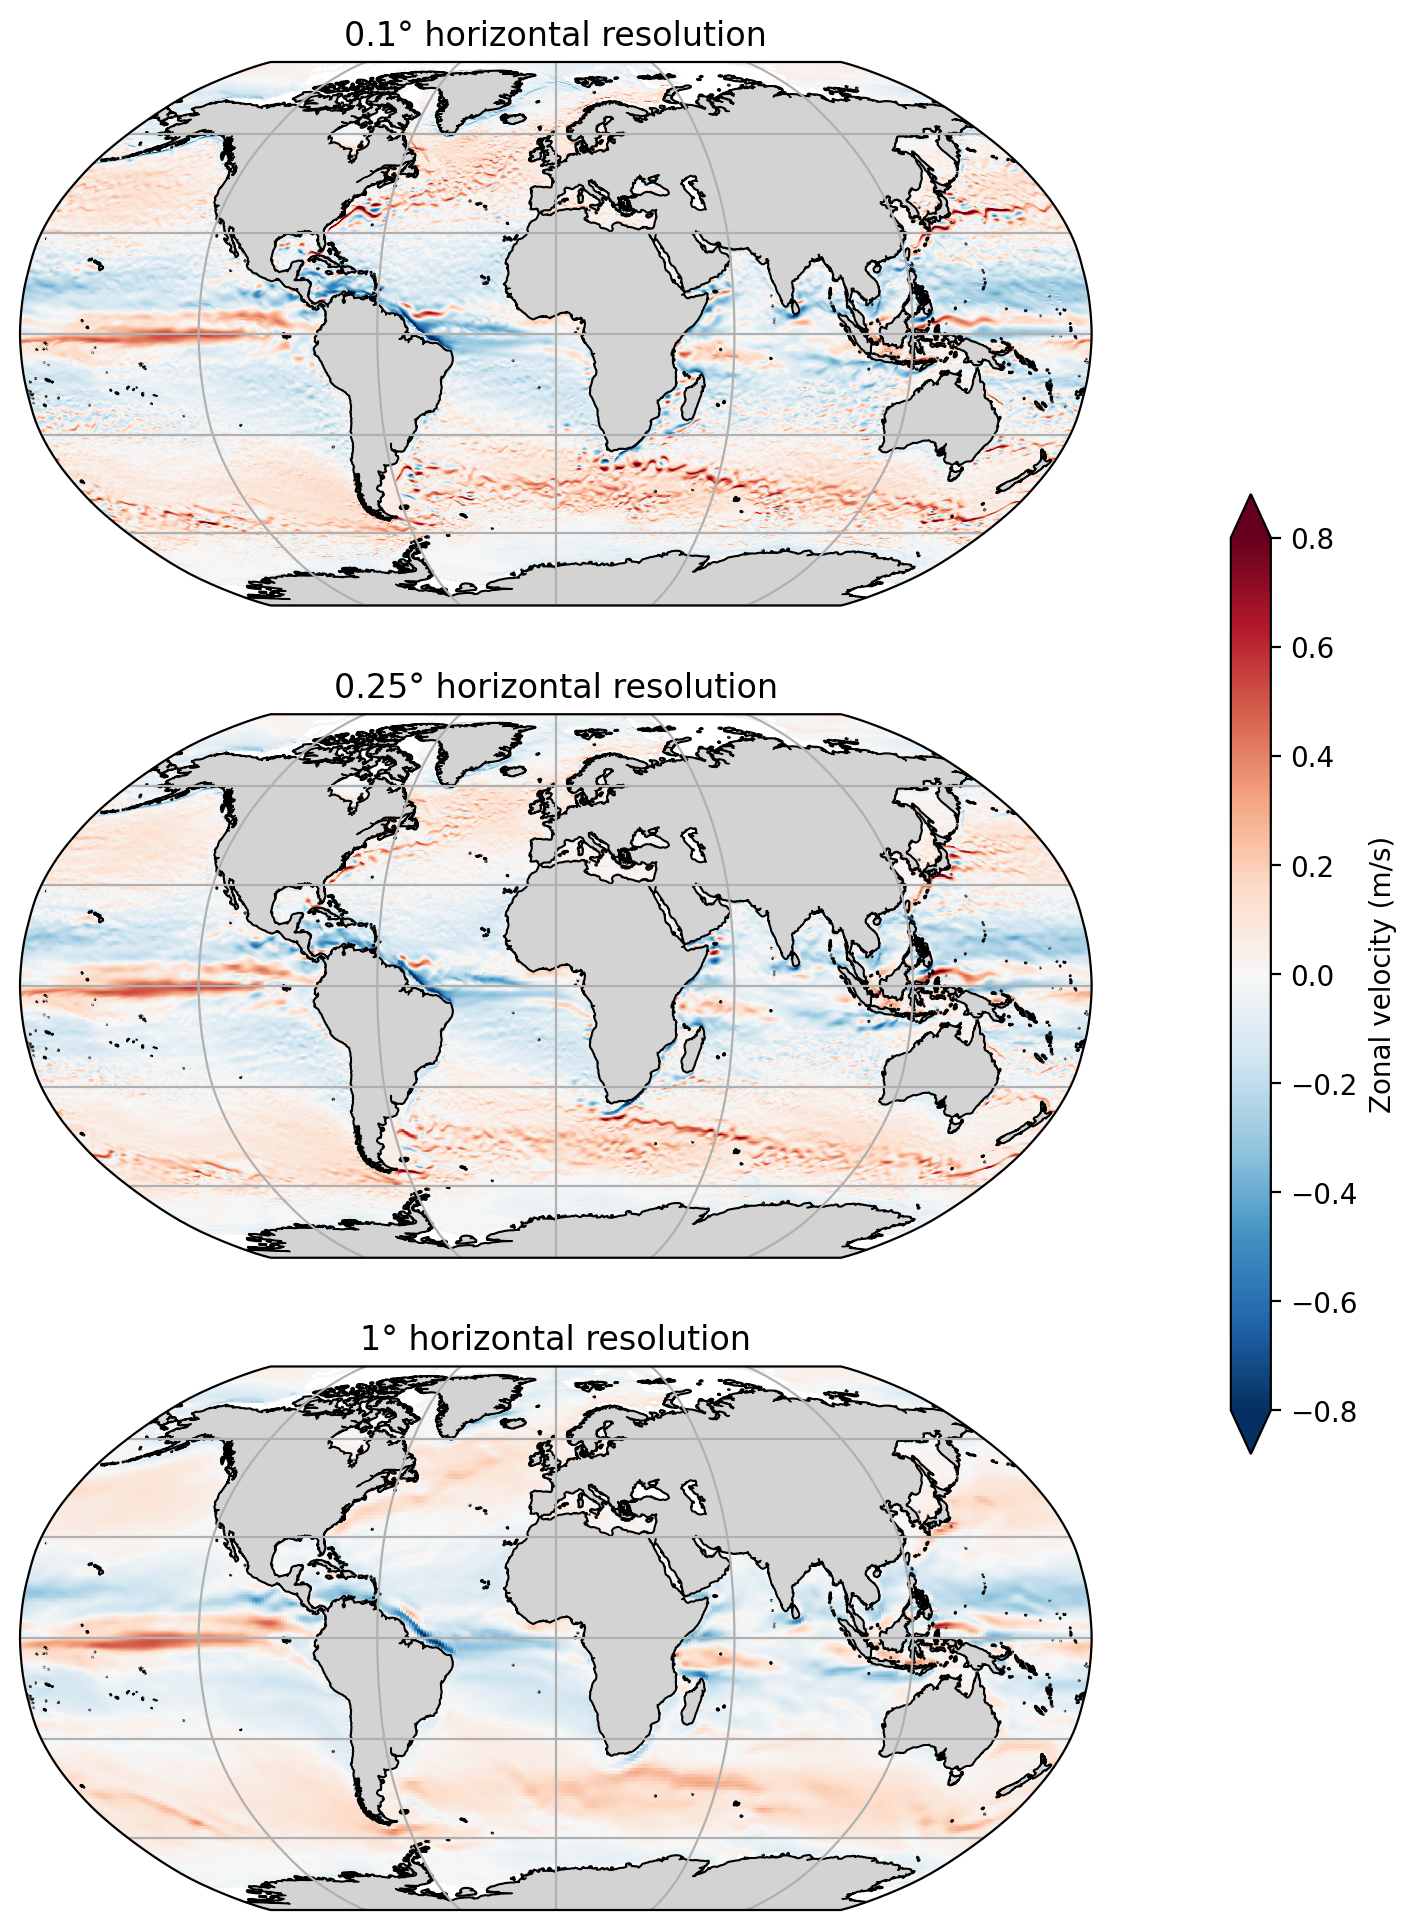

In [9]:
fig, axes = plt.subplots(nrows = 3, figsize = (10, 12),
                         subplot_kw={'projection': ccrs.Robinson()})

for counter, experiment in enumerate(experiments):
    ax = axes[counter]
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    ax.gridlines(draw_labels=False)
    
    u_snapshot = sims[experiment].u.sel(time=sims[experiment].time[-1])
    
    p = u_snapshot.plot(ax = ax,
                        x='xu_ocean', y='yu_ocean',
                        transform=ccrs.PlateCarree(),
                        cmap='RdBu_r', vmin=-0.8, vmax=0.8,
                        add_colorbar=False)

    ax.set_title(titles[counter])

ax_cb = plt.axes([0.85, 0.3, 0.02, 0.4])
plt.colorbar(p, cax=ax_cb, extend='both', label='Zonal velocity (m/s)');

The mesoscale variability hinted at in the above global figures is more easily seen by zooming into a regional scale. The plots below show the Atlantic sector of the Southern Ocean, including the Agulhas Current, and Drake Passage. The figures below also show that higher horizontal resolution support much higher flow speeds.

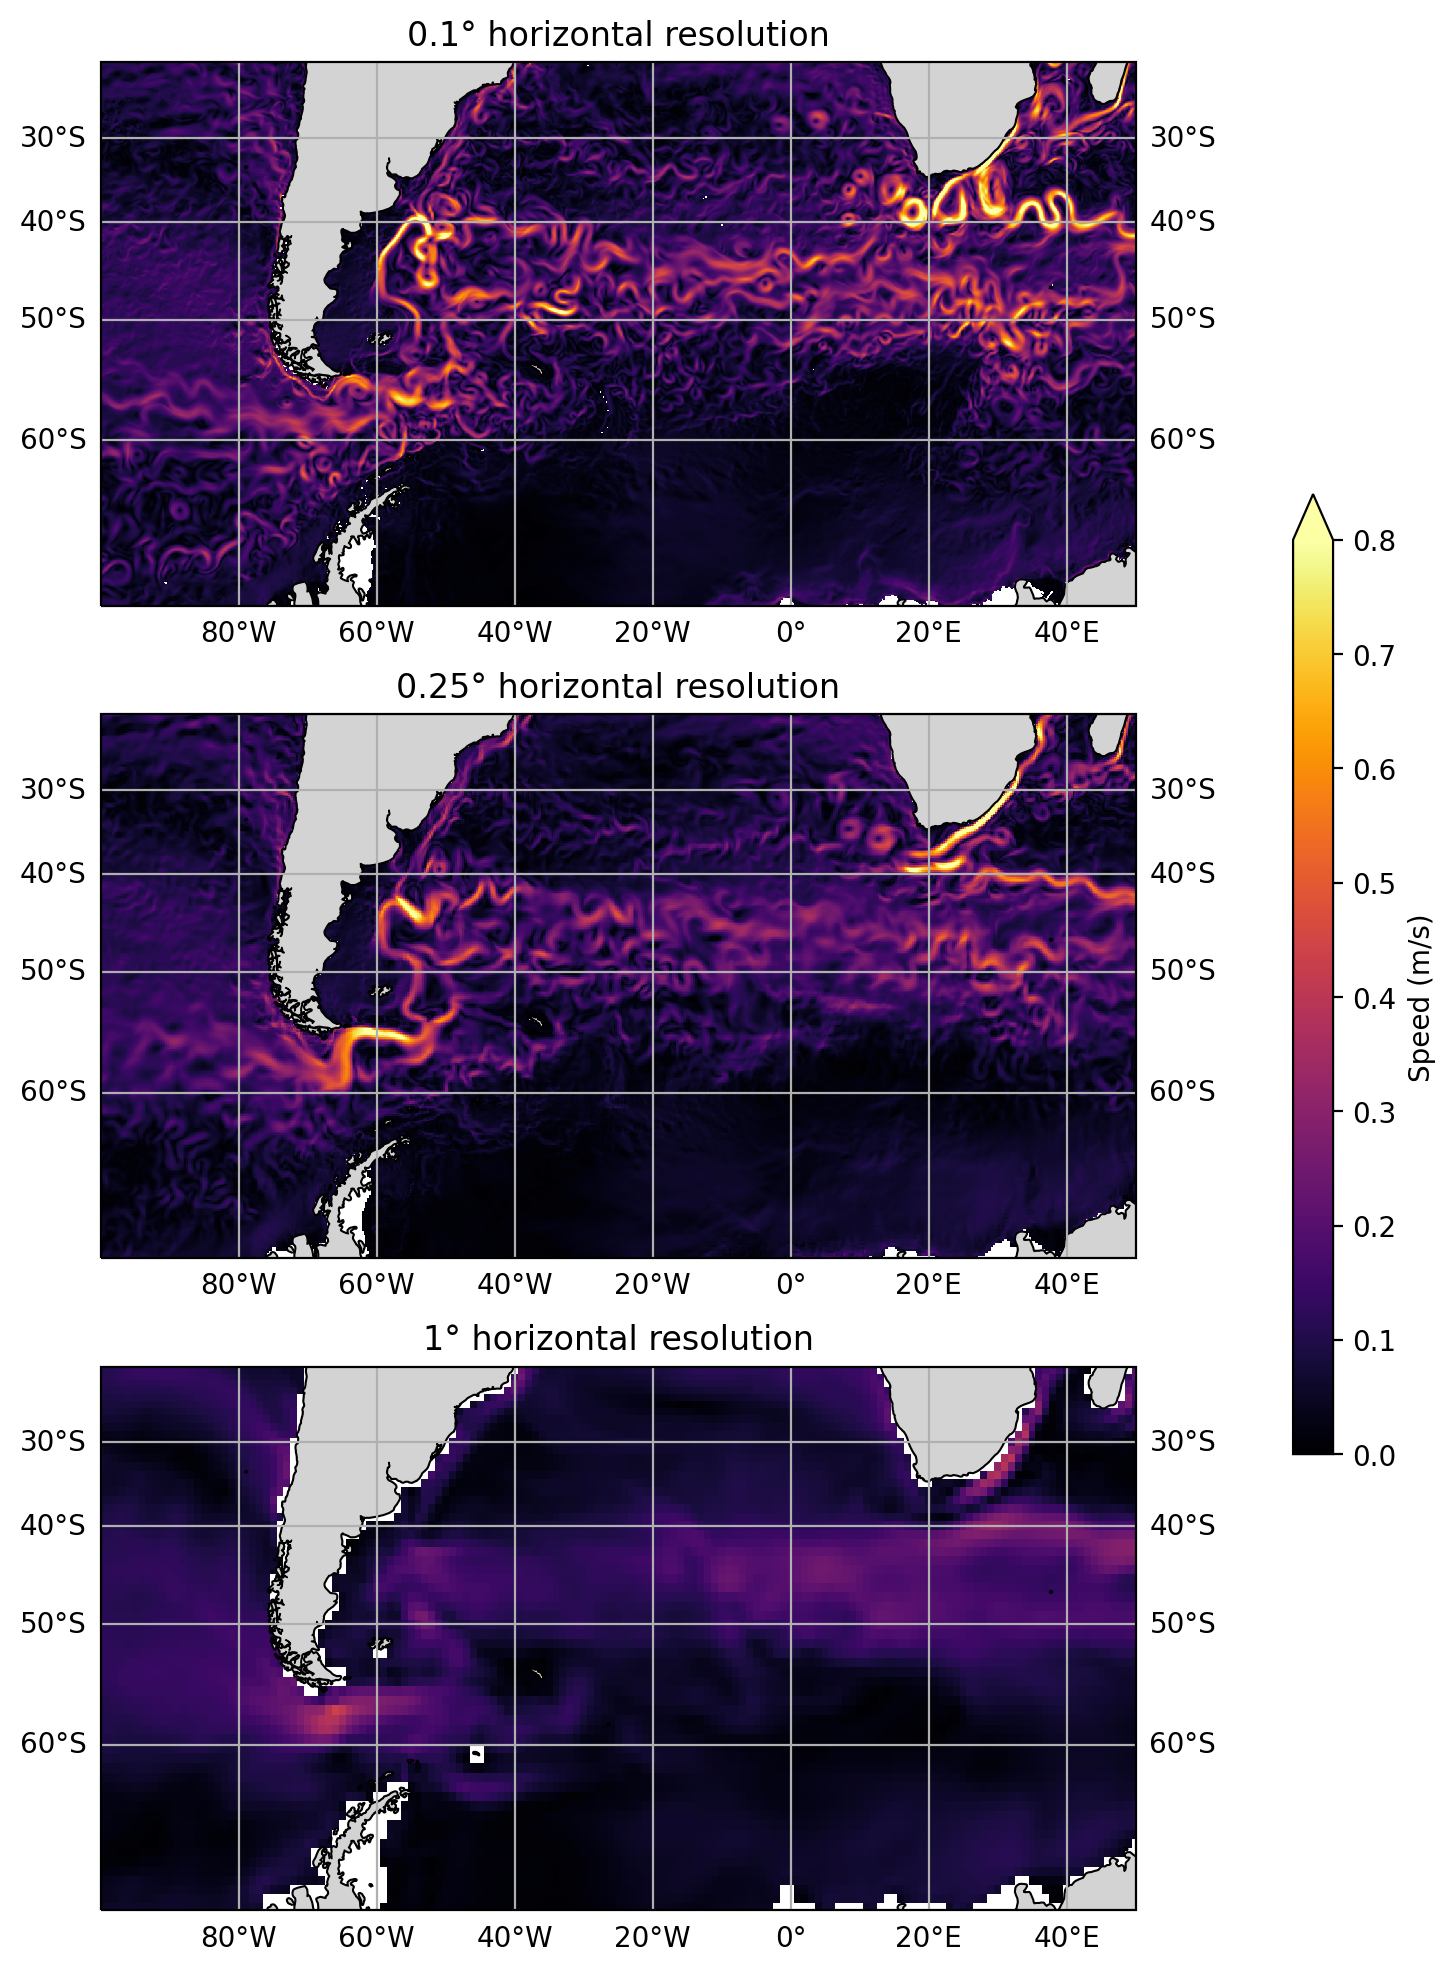

In [10]:
projection=ccrs.Mercator(central_longitude=0.0, min_latitude=-70.0, max_latitude=-20.0)

fig, axes = plt.subplots(nrows = 3, figsize = (10, 12),
                         subplot_kw={'projection': projection})

for counter, experiment in enumerate(experiments):
    ax = axes[counter]
    ax.set_extent([-100, 50, -70, -20], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    
    speed_snapshot = sims[experiment].speed.sel(time=sims[experiment].time[-1])
    
    p = speed_snapshot.plot(ax=ax,
                            x='xu_ocean', y='yu_ocean',
                            transform=ccrs.PlateCarree(),
                            cmap='inferno', vmin=0, vmax=0.8,
                            add_colorbar=False)

    ax.set_title(titles[counter])

ax_cb = plt.axes([0.85, 0.3, 0.02, 0.4])
plt.colorbar(p, cax=ax_cb, extend='max', label='Speed (m/s)');

The higher resolution simulations exhibit much more variability in their velocity fields. This can be easily seen by looking at eddy kinetic energy, defined as 

$$\text{EKE} = \frac1{2} \big[ (u - \overline{u})^{2} + (v-\overline{v})^{2} \big]$$

where overbar denotes a time average. Eddy kinetic energy picks out variability in the velocity fields. Again, we plot the final timestamp.

This plot takes quite some time to produce, since it requires averaging the entire time series of `u` and `v` for each simulation.

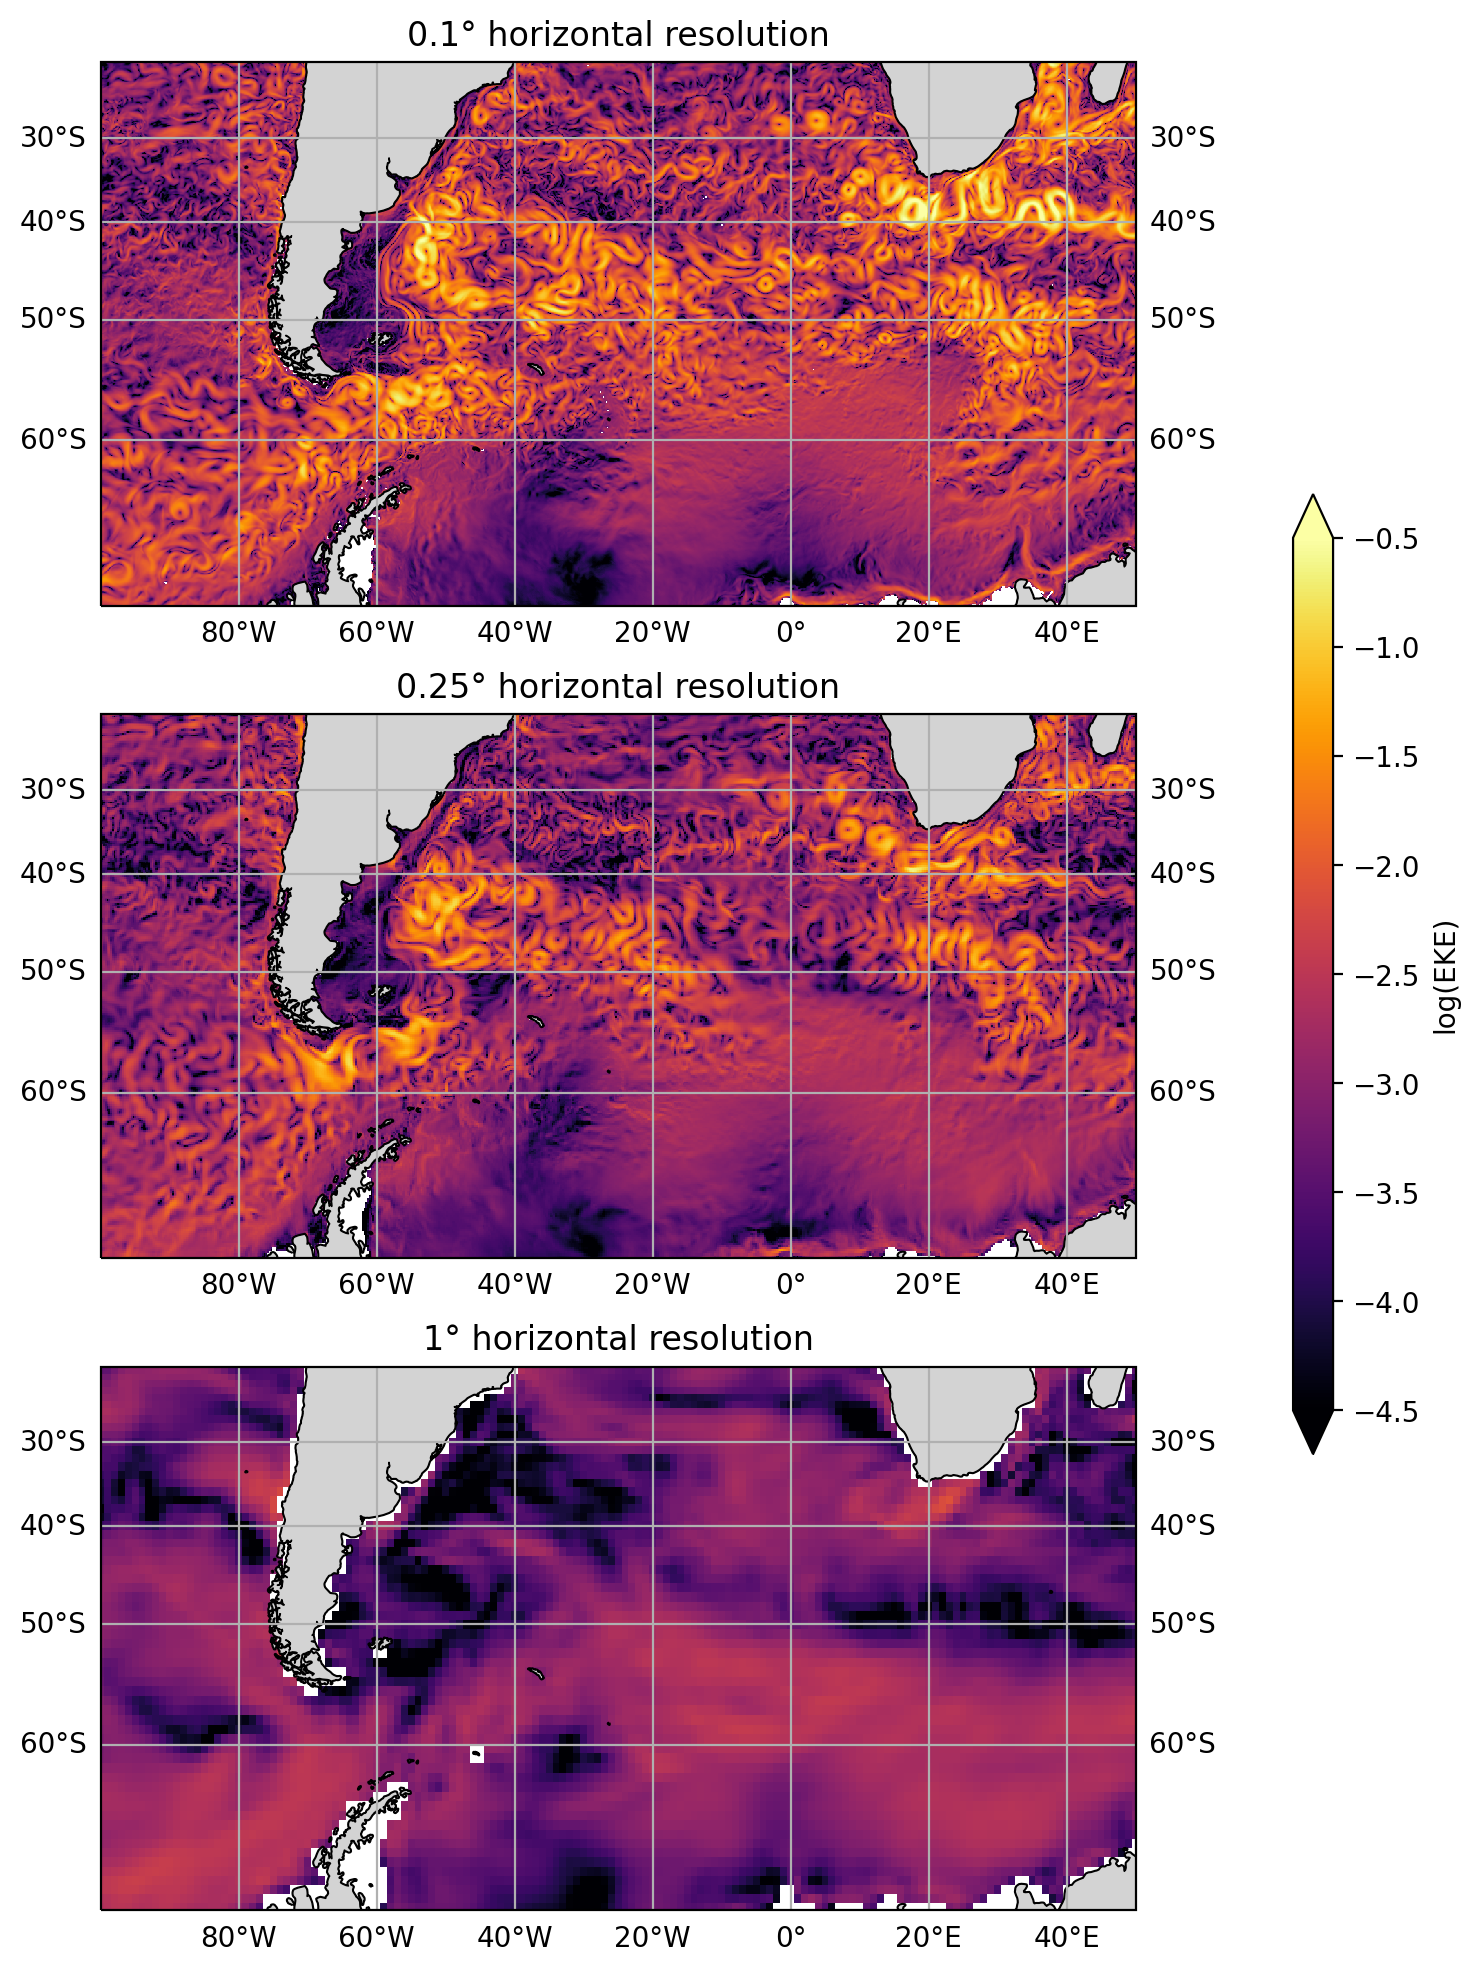

In [11]:
projection=ccrs.Mercator(central_longitude=0.0, min_latitude=-70.0, max_latitude=-20.0)

fig, axes = plt.subplots(nrows = 3, figsize = (10, 12),
                         subplot_kw={'projection': projection})

for counter, experiment in enumerate(experiments):
    ax = axes[counter]
    ax.set_extent([-100, 50, -70, -20], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    
    eke_snapshot = sims[experiment].eke.sel(time=sims[experiment].time[-1])
    
    p = np.log10(eke_snapshot).plot(ax=ax,
                                    x='xu_ocean', y='yu_ocean',
                                    transform=ccrs.PlateCarree(),
                                    cmap='inferno', vmin=-4.5, vmax=-0.5,
                                    add_colorbar=False)
    
    ax.set_title(titles[counter])

ax_cb = plt.axes([0.85, 0.3, 0.02, 0.4])
plt.colorbar(p, cax=ax_cb, extend='both', label='log(EKE)');